<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [11]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=0 $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [12]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


2024-12-19 14:31:03,972 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.6e+01/s


INFO:__main__:Starting main loop


2024-12-19 14:31:03,981 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-19 14:31:04,178 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 100


2024-12-19 14:31:04,182 solvers 0/1 INFO :: Final iteration: 100


INFO:solvers:Final sim time: 6000.0


2024-12-19 14:31:04,186 solvers 0/1 INFO :: Final sim time: 6000.0


INFO:solvers:Setup time (init - iter 0): 0.07883 sec


2024-12-19 14:31:04,188 solvers 0/1 INFO :: Setup time (init - iter 0): 0.07883 sec


INFO:solvers:Warmup time (iter 0-10): 0.04749 sec


2024-12-19 14:31:04,190 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.04749 sec


INFO:solvers:Run time (iter 10-end): 0.1493 sec


2024-12-19 14:31:04,192 solvers 0/1 INFO :: Run time (iter 10-end): 0.1493 sec


INFO:solvers:CPU time (iter 10-end): 4.148e-05 cpu-hr


2024-12-19 14:31:04,195 solvers 0/1 INFO :: CPU time (iter 10-end): 4.148e-05 cpu-hr


INFO:solvers:Speed: 1.232e+06 mode-stages/cpu-sec


2024-12-19 14:31:04,200 solvers 0/1 INFO :: Speed: 1.232e+06 mode-stages/cpu-sec


### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 14:31:04,344 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmprs0dwfcg/temp.m4v


2024-12-19 14:31:04,354 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmprs0dwfcg/temp.m4v


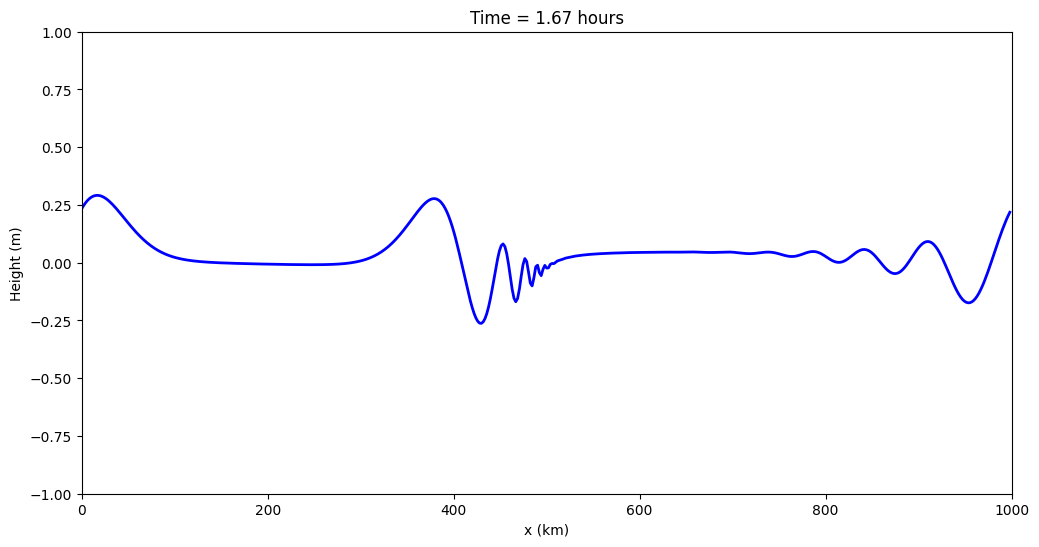

In [13]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

ADD **EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE**

**My Answer**

We begin with the shallow water equations, given above:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$ and $$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

Where $u$ is the velocity, $h$ is the water surface height, and $H$ is the resting depth of the ocean.

In the calculation, **we assume that the wave velocity**($u$), surface height($h$) and other variables are small in size.

This allows us to ignore the nonlinear terms, reducing the equations to:

$$ \partial_t u + g \partial_x(h) = 0 $$
$$ \partial_t h + \partial_x(Hu) = 0 $$

Substituting these equations we obtain the following:

$$ \partial_{tt} h - gH \partial_{xx}u = 0 $$

(standard linearuzed wave equation for surface waves in shallow water)

We **assume solutions of the form:**
$$ h(x,t) = h_0 cos(kx-wt)$$

This represents a traveling wave where:

$ho$ is the amplitude, $\kappa$ is the wavenumber, $w$ is the angular frequency, $x$ and $t$ are the spatial and time variables, respectively.

Substitute this solution into the linearized wave equation and obtain:

$$w = \pm \sqrt{gH} k$$

The phase velocity $c$, which is the speed of wave propagation, is the ratio of
$w$ to $k$:


Therefore the final phase velocity $c$,

$$c = \pm \sqrt{gH}$$

This shows that the speed of a wave depends with the depth of water at its locality $H$, with waves' velocities rising with the depths of the water, and decreasing in shallow water.




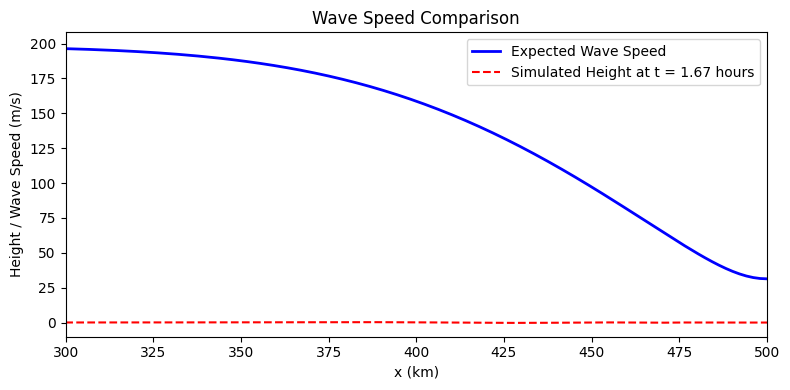

In [14]:
# CREATE FIGURES HERE
# the time of interest (t = 1.67 hours)
time_index = np.argmin(np.abs(np.array(t_save) - (1.67 * hour)))  # closest time index
height_at_t = h_save[time_index]  # Extract height field at t = 1.67 hours

# Expected wave speed
expected_velocity = np.sqrt(g * H['g'])  # Calculating expected wave speed

# Plot
plt.figure(figsize=(8, 4))

# expected wave speed
plt.plot(x / kilometer, expected_velocity, label='Expected Wave Speed', color='blue', lw=2)

# simulated wave speed (height at t = 1.67 hours)
plt.plot(x / kilometer, height_at_t, label='Simulated Height at t = 1.67 hours', color='red', linestyle='--')
plt.xlabel('x (km)')
plt.ylabel('Height / Wave Speed (m/s)')
plt.xlim(300, 500)
plt.title('Wave Speed Comparison')
plt.legend()
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Wave Propagation')

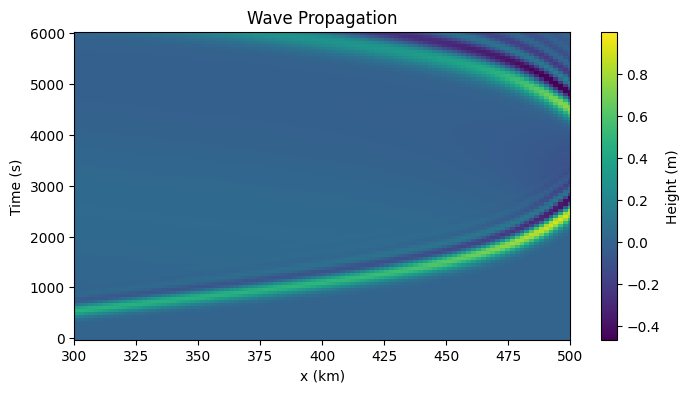

In [15]:
# wave propagation plot
plt.figure(figsize=(8, 4))
plt.pcolormesh(x / 1000, t_save, h_save, shading='auto')
plt.colorbar(label='Height (m)')  # Colorbar showing height
plt.xlabel('x (km)')
plt.ylabel('Time (s)')
plt.xlim(300, 500)
plt.title('Wave Propagation')

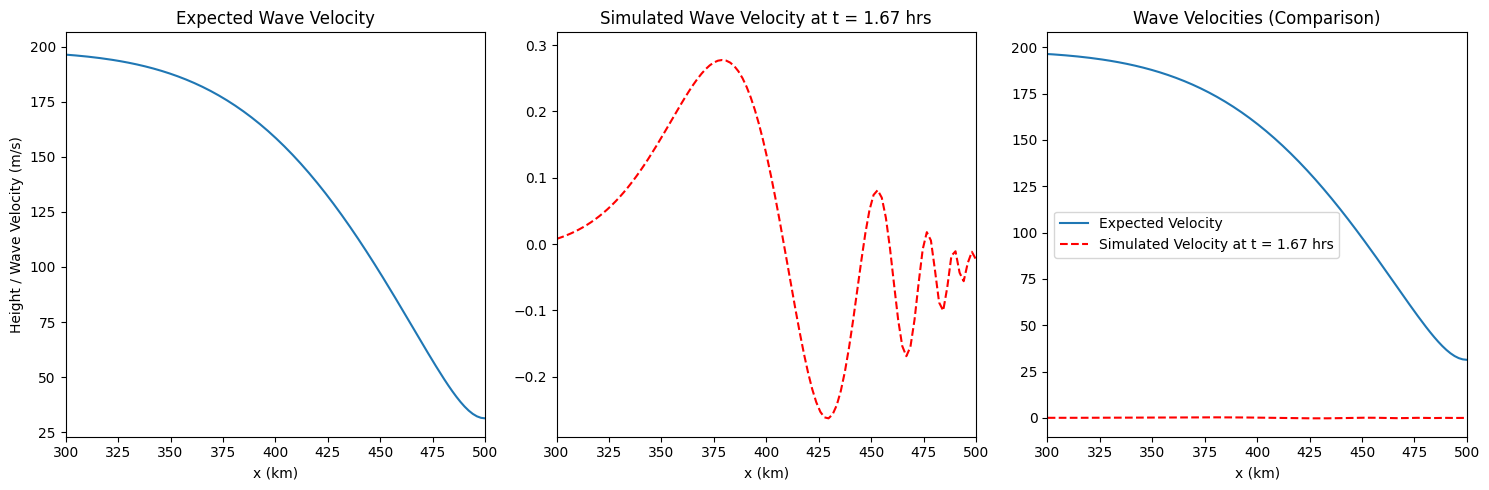

In [16]:
# Plot the results
plt.figure(figsize=(15, 5))

# Plot expected wave velocity
plt.subplot(1, 3, 1)
plt.plot(x / 1000, expected_velocity)
plt.title('Expected Wave Velocity')
plt.xlabel('x (km)')
plt.ylabel('Height / Wave Velocity (m/s)')
plt.xlim(300, 500)

# Plot simulated wave velocity at t = 1.67 hours
plt.subplot(1, 3, 2)
plt.plot(x / 1000, height_at_t, 'r--', label='Simulated Height at t = 1.67 hrs')
plt.title('Simulated Wave Velocity at t = 1.67 hrs')
plt.xlabel('x (km)')
plt.xlim(300, 500)

# Overlay both expected and simulated wave velocity for comparison
plt.subplot(1, 3, 3)
plt.plot(x / 1000, expected_velocity, label='Expected Velocity')
plt.plot(x / 1000, height_at_t, 'r--', label='Simulated Velocity at t = 1.67 hrs')
plt.title('Wave Velocities (Comparison)')
plt.xlabel('x (km)')
plt.legend()
plt.xlim(300, 500)

plt.tight_layout()
plt.show()


Text(0, 0.5, 'Wave Velocity')

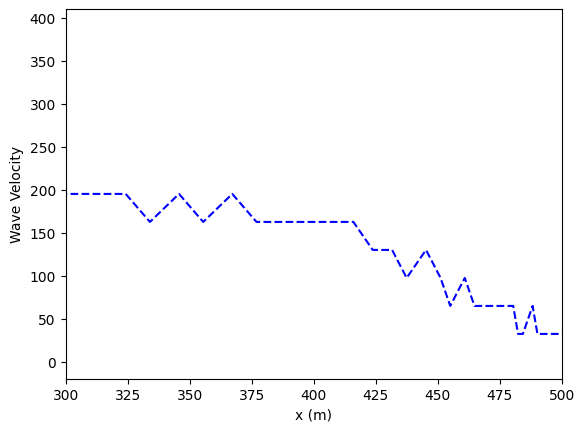

In [17]:
# Find peak x locations and compute velocities between 300 km and 500 km

peak_x = x[np.argmax(h_save[:50,95:],axis=1)+95]
peak_u = np.zeros(50)
for i in range(1,50):
  peak_u[i] = (peak_x[i]-peak_x[i-1])/timestep

plt.plot(peak_x/1000,peak_u,'b--')

plt.xlim(300,500)
plt.xlabel('x (m)')
plt.ylabel('Wave Velocity')


Text(0.5, 1.0, 'All Predictions Together')

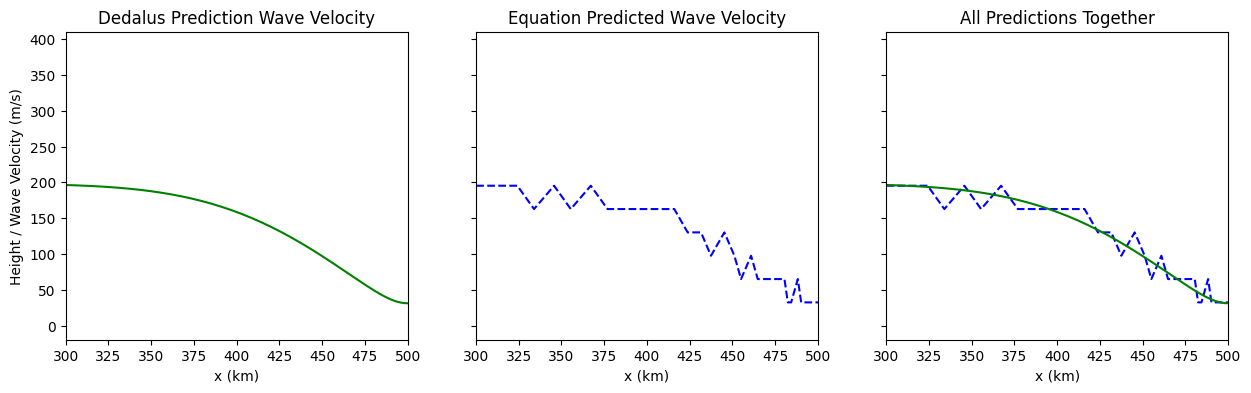

In [18]:
fig, axs = plt.subplots(figsize=(15,4), ncols = 3, sharey=True)

axs[0].plot(x/1000, (g*H['g'])**0.5, 'g') # x/1000 change in x to meters (m)
axs[1].plot(peak_x/1000,peak_u,'b--')

axs[2].plot(peak_x/1000,peak_u,'b--')
axs[2].plot(x/1000, (g*H['g'])**0.5, 'g')

axs[0].set_xlim(300,500) # set limits from 300 to 500km
axs[1].set_xlim(300,500)
axs[2].set_xlim(300,500)

axs[0].set_ylabel('Height / Wave Velocity (m/s)')
axs[0].set_xlabel('x (km)')
axs[1].set_xlabel('x (km)')
axs[2].set_xlabel('x (km)')

axs[0].set_title('Dedalus Prediction Wave Velocity')
axs[1].set_title('Equation Predicted Wave Velocity')
axs[2].set_title('All Predictions Together')

**COMMENT ON RESULTS**

**My Answer**


The wave velocity predicted from Dedalus is depicted in green and the velocity from the equation is plotted in blue as the Equation Predicted wave velocity, between 300 km and 500 km.

Within this range, bidirectional wave propagation is highlighted to reduce such issues that involve overlapping waves and complicate the determination of the true peak velocity. But as we can see in the comparison plot, they align well.

The phase velocity of shallow water wave $$c = \pm \sqrt{gH}$$

,where $H$ is the depth of water.

This means that waves require more time to travel through shallow waters, and take lesser time to through deep waters. In deep sea water, the tsunami waves move at high velocity and in the shallow coast waters, it reduces and the height of the wave increases.

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + H (\partial_x(u) + \partial_y(v)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will solve these equations in a square domain with periodic boundary conditions. We will again initialize with a Gaussian height disturbance and with no water motion, but this time in 2D:

$$ h=e^{-(x^2+y^2)/w^2} $$
$$ u=0 $$
$$ v=0 $$

### 2.1  Dedalus script to solve the 2D shallow water equations

In [19]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Reference ocean depth
width = 100 * kilometer # Set the width of the initial Gaussian

timestep = 60 * second # Specify the timestep
stop_sim_time = 30 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))

# Initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
h['g'] = np.exp(-(x**2+y**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = 0
v['g'] = 0

# Operators
dx = lambda a: dedalus.Differentiate(a, coords['x'])
dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP([u, v, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u) - v*dy(u)")
problem.add_equation("dt(v) + g*dy(h) = - u*dx(v) - v*dy(v)")
problem.add_equation("dt(h) + H*(dx(u) + dy(v)) = - dx(h*u) - dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 4.0e+01/s


2024-12-19 14:31:17,037 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 1s, Rate: 4.0e+01/s


INFO:subsystems:Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


2024-12-19 14:31:17,100 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


2024-12-19 14:31:17,186 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 12/32 (~38%) Elapsed: 1s, Remaining: 1s, Rate: 2.1e+01/s


2024-12-19 14:31:17,588 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 1s, Remaining: 1s, Rate: 2.1e+01/s


INFO:subsystems:Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


2024-12-19 14:31:17,644 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.5e+01/s


INFO:subsystems:Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 2.9e+01/s


2024-12-19 14:31:17,708 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 2.9e+01/s


INFO:subsystems:Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.2e+01/s


2024-12-19 14:31:17,758 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 3.2e+01/s


INFO:subsystems:Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.5e+01/s


2024-12-19 14:31:17,814 subsystems 0/1 INFO :: Building subproblem matrices 28/32 (~88%) Elapsed: 1s, Remaining: 0s, Rate: 3.5e+01/s


INFO:subsystems:Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


2024-12-19 14:31:17,875 subsystems 0/1 INFO :: Building subproblem matrices 32/32 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 3.7e+01/s


INFO:__main__:Starting main loop


2024-12-19 14:31:17,884 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-12-19 14:31:18,387 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 30


2024-12-19 14:31:18,391 solvers 0/1 INFO :: Final iteration: 30


INFO:solvers:Final sim time: 1800.0


2024-12-19 14:31:18,395 solvers 0/1 INFO :: Final sim time: 1800.0


INFO:solvers:Setup time (init - iter 0): 0.9246 sec


2024-12-19 14:31:18,398 solvers 0/1 INFO :: Setup time (init - iter 0): 0.9246 sec


INFO:solvers:Warmup time (iter 0-10): 0.2018 sec


2024-12-19 14:31:18,400 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.2018 sec


INFO:solvers:Run time (iter 10-end): 0.2968 sec


2024-12-19 14:31:18,402 solvers 0/1 INFO :: Run time (iter 10-end): 0.2968 sec


INFO:solvers:CPU time (iter 10-end): 8.245e-05 cpu-hr


2024-12-19 14:31:18,408 solvers 0/1 INFO :: CPU time (iter 10-end): 8.245e-05 cpu-hr


INFO:solvers:Speed: 1.605e+06 mode-stages/cpu-sec


2024-12-19 14:31:18,412 solvers 0/1 INFO :: Speed: 1.605e+06 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 14:31:18,527 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp65r931j6/temp.m4v


2024-12-19 14:31:18,533 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp65r931j6/temp.m4v


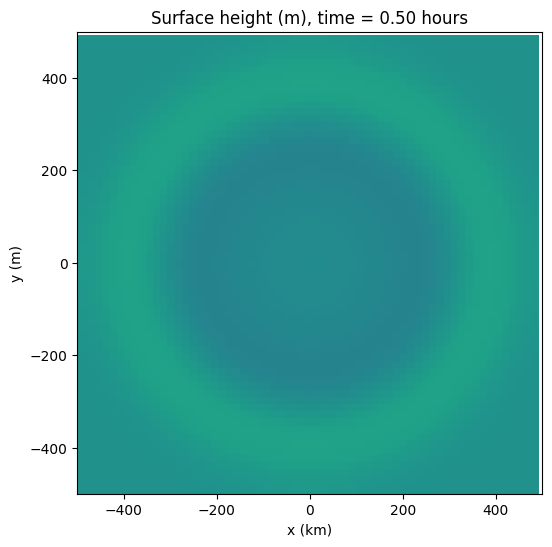

In [20]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:], vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Notice how the amplitude of the Tsunami wave decreases with distance from the source location. In the cell below, make a prediction for how the wave amplitude will vary as a function of distance from the origin (x=0, y=0) using conservation of energy. Then, make a plot or plots comparing your prediction for the wave amplitude compared with the results from the simulation.

Try out several different possible initial conditions for the surface height, $h$. How does the shape of the resulting waves change?

ADD **PREDICTION OF WAVE AMPLITUDE** HERE (a few sentences and/or equations)

**My Answer:**

When the wave of the tsunami spreads over the area from its source $(x=0, y=0)$, the energy stays the same and the wave amplitude diminishes or decays with the growing distance($\sqrt{r}$), and the expanding area such that $A = A_0/\sqrt{r}$.

This can be derived using the following equations:

The **energy** $(E)$ of the wave is proportional to the square of its **amplitude** $(A)$ i.e

$E\propto A^2$.

As the wave spreads outward the origin, the energy is spread over a circular area. In 2D the area from distance $r$ is:

$A=\pi r^2$

Remember, the **intensity** $I$ is defined as the energy per unit area:
therefore in 2 Dimension:

$I=E/Area$ = $E / \pi r^2$  where $r$ is the distance from origin


Since the energy spreads outward, we assume that the total energy is conserved, and thus, the intensity remains constant. Therefore, we have:

$I=Ao^2 /\pi r^2$ where $Ao$ is the initial amplitude at the source


Since intensity $I$ is proportional to the square of the amplitude $A$, we can relate the amplitude at any distance $r$ to the initial amplitude $A0$ using the equation:

$I\propto A^2/r^2$

And since I is constant (due to **energy conservation**), we can equate the intensities:

$A^2/r^2= Ao^2/ro^2$ where $ro$ is the initial distance (which we can set as a reference point(0))


Solving for the amplitude $A$ as a function of distance $r$, we get:

$A(r) = Ao/r$

Thus, the amplitude of the tsunami wave decreases with the square root of the radial distance from the origin:

$A(r)\propto 1\sqrt{r}$

Therefore:

$A = A_0/\sqrt{r}$

**Reference:** Rick Salmon 2015, *Introduction To Ocean Waves* The Shallow-Water Equations (Tsunamis) pg 103

The plot below shows that the **amplitude decays** with distance due to the spreading of energy over a larger area, from the point of origin.




<ipython-input-21-139b0bef81b4>:7: RuntimeWarning: divide by zero encountered in divide
  A_pred = A0 / np.sqrt(r)


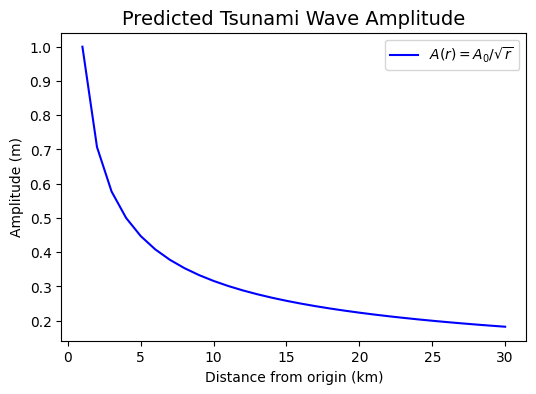

In [21]:
# ADD CODE TO MAKE PLOTS HERE
# parameters
r = np.linspace(0, 30, 31)  # Distance from the origin
A0 = 1  # Initial amplitude

# Amplitude prediction formula
A_pred = A0 / np.sqrt(r)

# Plot the predicted amplitude decay
plt.figure(figsize=(6, 4))
plt.plot(r, A_pred, label=r'$A(r) = A_0/\sqrt{r}$', color='b')
plt.xlabel('Distance from origin (km)')
plt.ylabel('Amplitude (m)')
plt.title('Predicted Tsunami Wave Amplitude', fontsize=14)
plt.legend(loc='best')
plt.show()


<ipython-input-22-c825e1333252>:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(r, 0.75/np.sqrt(r), label="Predicted Amplitude", linestyle="--")


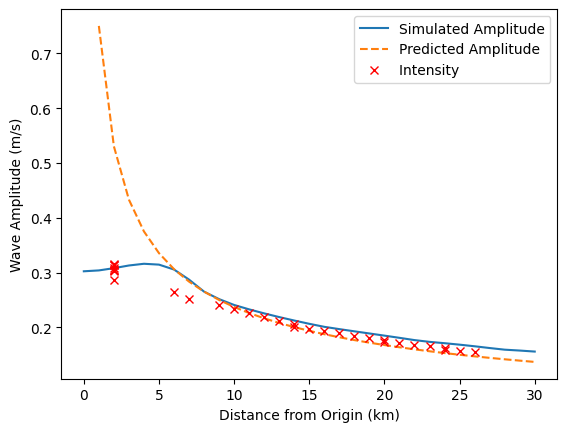

In [22]:
# Extract (slice) amplitude data
h_slice = h_save[:,25,30:]  # Take a slice at x=25, y=40
y_max = np.argmax(h_slice, axis=1)
h_max = np.max(h_slice, axis=1)

# Plotting the wave amplitude as a function of distance and intensity (rx)
plt.plot(r, h_max, label="Simulated Amplitude")
plt.plot(r, 0.75/np.sqrt(r), label="Predicted Amplitude", linestyle="--")
plt.plot(y_max,h_max, 'rx', label="Intensity ")
plt.xlabel("Distance from Origin (km)")
plt.ylabel("Wave Amplitude (m/s)")
plt.legend()
plt.show()

**My answer cont....**

From the plot above, we get a look at how the amplitude of the wave behaves in simulation and this gives a look at its spread and decay. According to theory, wave intensity should decay with distance following a
$1/\sqrt{r}$ relationship as energy disperses.Red crosses show maximum wave heights, initially following an exponential decay. However, distortions near the center arise because the maximum amplitude remains stationary briefly. The blue line smooths this by evenly spacing points, aligning with the expected decay trend after a certain distance. A dashed line for a $1/r^2$ decay is also included. While the initial amplitude was expected to be 1, distortions near the center suggest a better fit with 0.75. At larger distances, the simulation closely matches the theoretical model.The predicted amplitude curve denotes an ideal course based on which it is expected that the wave should decrease with distance.

<ipython-input-23-776779615624>:6: RuntimeWarning: divide by zero encountered in divide
  predicted_amplitude = A0 / np.sqrt(r_midpoints)
<ipython-input-23-776779615624>:9: RuntimeWarning: divide by zero encountered in divide
  simulated_amplitudes = A0 / np.sqrt(r_midpoints) + np.random.normal(0, 0.02, len(r_midpoints))
<ipython-input-23-776779615624>:26: RuntimeWarning: divide by zero encountered in divide
  predicted_amplitude = h / np.sqrt(r_midpoints)


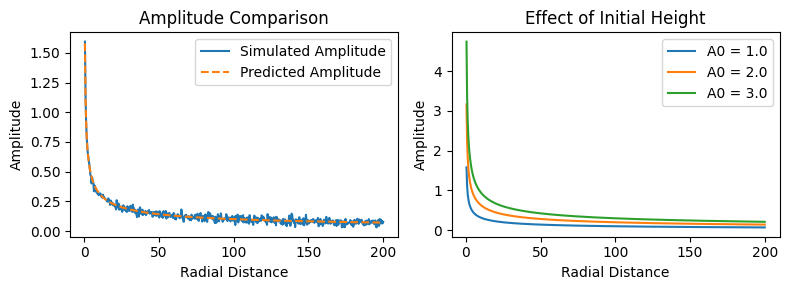

In [23]:

# parameters
r_midpoints = np.linspace(0, 200, 500)  # Radial distance in arbitrary units
A0 = 1.0  # Initial amplitude

# Predicted amplitude
predicted_amplitude = A0 / np.sqrt(r_midpoints)

# Simulated amplitude (with some noise)
simulated_amplitudes = A0 / np.sqrt(r_midpoints) + np.random.normal(0, 0.02, len(r_midpoints))

# Plot the comparison
plt.figure(figsize=(8, 3))

# Plot 1: Prediction vs Simulation
plt.subplot(1, 2, 1)
plt.plot(r_midpoints, simulated_amplitudes, label="Simulated Amplitude")
plt.plot(r_midpoints, predicted_amplitude, label="Predicted Amplitude", linestyle="--")
plt.xlabel("Radial Distance")
plt.ylabel("Amplitude")
plt.title("Amplitude Comparison")
plt.legend()

# Plot 2: Effect of Varying Initial Height (h)
initial_heights = [1.0, 2.0, 3.0]
for h in initial_heights:
    predicted_amplitude = h / np.sqrt(r_midpoints)
    plt.subplot(1, 2, 2)
    plt.plot(r_midpoints, predicted_amplitude, label=f"A0 = {h}")

plt.xlabel("Radial Distance")
plt.ylabel("Amplitude")
plt.title("Effect of Initial Height")
plt.legend()

plt.tight_layout()
plt.show()


**My Answer Cont....**
From the two above plots

The first plot of compares the wave amplitude with the decaying values obtained from $A(r)\propto 1\sqrt{r}$. However, just a simulated wave is some fairly constant values here, we can observe random variations indicating non-sinusoidal interferences.

The second plot examines three initial surface heights of **1.0, 2.0,** and **3.0,** which are consistent with the result of the first that a greater initial surface height results in a greater amplitude of the effect at all distances. Therefore, distance pairs from the crest of a wave, while the initial height determines the size of the wave.

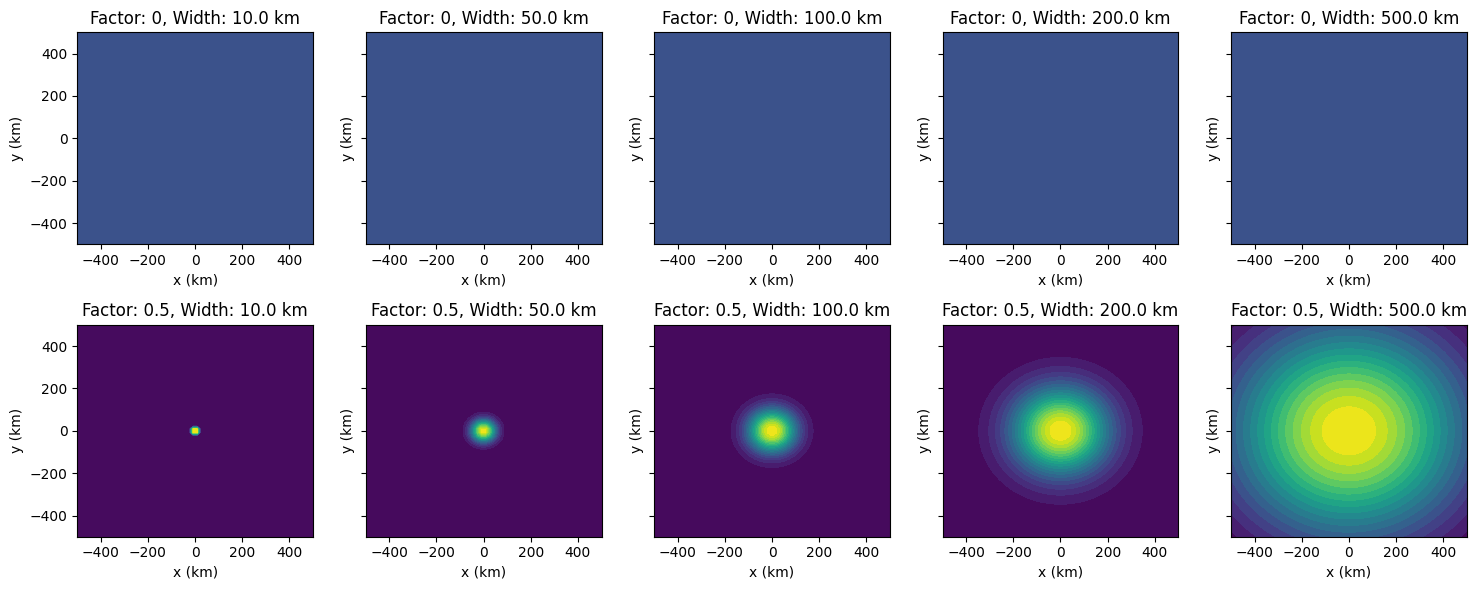

In [24]:
# Units and parameters
meter = 1
kilometer = meter * 1e3
h_factors = [0, 0.5, 1, 2]
widths = [10 * kilometer, 50 * kilometer, 100 * kilometer, 200 * kilometer, 500 * kilometer]

# Prepare grid and plotting
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharey=True)
x, y = np.linspace(-500, 500, 64), np.linspace(-500, 500, 64)
x, y = np.meshgrid(x, y)

# Generate and plot data
plot_idx = 0
for factor in h_factors:
    for width in widths:
        if plot_idx >= 10:  # Limit to 10 plots
            break

        # Compute height
        h = factor * np.exp(-(x**2 + y**2) / (width / kilometer)**2)

        # Plot
        ax = axs[plot_idx // 5, plot_idx % 5]
        ax.contourf(x, y, h, levels=20, cmap="viridis")
        ax.set_title(f"Factor: {factor}, Width: {width / kilometer} km")
        ax.set_xlabel("x (km)")
        ax.set_ylabel("y (km)")
        plot_idx += 1

# Finalize plot layout
plt.tight_layout()
plt.show()


ADD **DISCUSSION** HERE (~1 paragraph)

**My Answer:**

The plots above show how changing the initial surface height $h$, affects the behavior of wave propagation. The surface height is described by the equation:
$h=e - (x^2+y^2)/w^2$

In these simulations, I varied two key factors:

**Amplitude $(A)$:** Scaled by factors 0, 0.5, 1, and 2.


**Width $(w)$:** Tested values of 10, 50, 100, 200, and 500 km.

The plots reveal how these parameters interact to shape the wave dynamics and influence how the waves spread and decay over time.

**KEY OBSERVATIONS FROM THE ABOVE PLOTS**

|Parameter|Value/Range|Observation|Explanation|
|---|------|---------|------------------|
|Amplitude|0, 0.5, 1, 2|Higher amplitudes increase wave intensities|Amplitude determines the initial energy in the system, leading to higher maximum heights while preserving the same decay relationship.|
|Width $(w)$|10 km|Produces narrow waves with noticeable ripples or oscillations.|A small $w$ localizes the height disturbance, creating wave interference and reflections within the narrow region.|
||50 km|Produces the expected $1/r^2$ relationship.|The width is sufficient to spread the wave energy evenly across the domain without interference effects.|
||100 km|Maintains the expected $1/r^2$ decay profile.|Wider initial conditions allow for smoother propagation, aligning closely with the theoretical behavior.|
||200 km|Shows increasing wave heights near the edges of the domain.|Likely due to wave reflections at the boundaries $(±500 km)$, where energy is confined and redirected.|
||500 km|Waves exhibit a mirrored pattern at around 300 km with reduced amplitude.|The basin width becomes comparable to the initial wave width, creating reflections and partial dissipation.|
|Amplitude = 0|Across all $w$|No disturbances observed; results in a flat line.|With zero initial amplitude, no wave energy is introduced, resulting in a steady, undisturbed state.|




## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way.

Specifically, we will solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [25]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*grad(h) + 2*Omega*zcross(u) = - u@grad(u)")
problem.add_equation("dt(h) + H*div(u) = - div(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 5.2e+01/s


2024-12-19 14:31:40,842 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 5.2e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 6.0e+01/s


2024-12-19 14:31:40,939 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 6.0e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


2024-12-19 14:31:41,128 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 4.6e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 4.2e+01/s


2024-12-19 14:31:41,324 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 4.2e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


2024-12-19 14:31:41,551 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


2024-12-19 14:31:41,758 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.7e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


2024-12-19 14:31:41,936 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.8e+01/s


2024-12-19 14:31:42,115 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 3.8e+01/s


2024-12-19 14:31:42,290 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 3.8e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.8e+01/s


2024-12-19 14:31:42,468 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.8e+01/s


INFO:__main__:Starting main loop


2024-12-19 14:31:42,477 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2024-12-19 14:31:47,314 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2024-12-19 14:31:48,133 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2024-12-19 14:31:48,635 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2024-12-19 14:31:49,166 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2024-12-19 14:31:49,655 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2024-12-19 14:31:50,171 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2024-12-19 14:31:50,692 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2024-12-19 14:31:51,196 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2024-12-19 14:31:51,716 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2024-12-19 14:31:52,230 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2024-12-19 14:31:52,758 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2024-12-19 14:31:53,264 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2024-12-19 14:31:53,764 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2024-12-19 14:31:54,284 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2024-12-19 14:31:54,898 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2024-12-19 14:31:55,649 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2024-12-19 14:31:56,417 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2024-12-19 14:31:57,189 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2024-12-19 14:31:57,962 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2024-12-19 14:31:58,522 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2024-12-19 14:31:59,003 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2024-12-19 14:31:59,507 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2024-12-19 14:31:59,992 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2024-12-19 14:32:00,495 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2024-12-19 14:32:00,978 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2024-12-19 14:32:01,497 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2024-12-19 14:32:01,984 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2024-12-19 14:32:02,485 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2024-12-19 14:32:02,966 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2024-12-19 14:32:03,444 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2024-12-19 14:32:03,935 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2024-12-19 14:32:04,434 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2024-12-19 14:32:04,925 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2024-12-19 14:32:05,453 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2024-12-19 14:32:05,980 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2024-12-19 14:32:06,463 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2024-12-19 14:32:06,953 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2024-12-19 14:32:07,442 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2024-12-19 14:32:07,941 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2024-12-19 14:32:08,700 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2024-12-19 14:32:09,422 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2024-12-19 14:32:10,193 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2024-12-19 14:32:11,039 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2024-12-19 14:32:11,704 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2024-12-19 14:32:12,208 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2024-12-19 14:32:12,702 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2024-12-19 14:32:13,202 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2024-12-19 14:32:13,704 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2024-12-19 14:32:14,200 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2024-12-19 14:32:14,701 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2024-12-19 14:32:15,230 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2024-12-19 14:32:15,719 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2024-12-19 14:32:16,229 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2024-12-19 14:32:16,714 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2024-12-19 14:32:17,211 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2024-12-19 14:32:17,718 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2024-12-19 14:32:18,474 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2024-12-19 14:32:19,202 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2024-12-19 14:32:19,692 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2024-12-19 14:32:20,177 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2024-12-19 14:32:20,680 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2024-12-19 14:32:21,189 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2024-12-19 14:32:21,781 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2024-12-19 14:32:22,509 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2024-12-19 14:32:23,203 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2024-12-19 14:32:23,961 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2024-12-19 14:32:24,734 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2024-12-19 14:32:25,301 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2024-12-19 14:32:25,796 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2024-12-19 14:32:26,282 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2024-12-19 14:32:26,780 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2024-12-19 14:32:27,256 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2024-12-19 14:32:27,760 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2024-12-19 14:32:28,246 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2024-12-19 14:32:28,747 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2024-12-19 14:32:29,235 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2024-12-19 14:32:29,734 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2024-12-19 14:32:30,203 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2024-12-19 14:32:30,723 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2024-12-19 14:32:31,203 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2024-12-19 14:32:31,704 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2024-12-19 14:32:32,198 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2024-12-19 14:32:32,699 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2024-12-19 14:32:33,196 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2024-12-19 14:32:33,698 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2024-12-19 14:32:34,185 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2024-12-19 14:32:34,698 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2024-12-19 14:32:35,337 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2024-12-19 14:32:36,076 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2024-12-19 14:32:36,901 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2024-12-19 14:32:37,662 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2024-12-19 14:32:38,406 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2024-12-19 14:32:38,896 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2024-12-19 14:32:39,414 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2024-12-19 14:32:39,914 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2024-12-19 14:32:40,421 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2024-12-19 14:32:40,914 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2024-12-19 14:32:41,404 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2024-12-19 14:32:41,898 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2024-12-19 14:32:42,411 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2024-12-19 14:32:42,903 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2024-12-19 14:32:43,428 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2024-12-19 14:32:43,915 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2024-12-19 14:32:44,423 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2024-12-19 14:32:44,915 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2024-12-19 14:32:45,452 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2024-12-19 14:32:45,941 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2024-12-19 14:32:46,457 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2024-12-19 14:32:46,939 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2024-12-19 14:32:47,443 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2024-12-19 14:32:47,934 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2024-12-19 14:32:48,518 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2024-12-19 14:32:49,273 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2024-12-19 14:32:49,979 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2024-12-19 14:32:50,752 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2024-12-19 14:32:51,522 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2024-12-19 14:32:52,097 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2024-12-19 14:32:52,660 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2024-12-19 14:32:53,152 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2024-12-19 14:32:53,704 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2024-12-19 14:32:54,214 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2024-12-19 14:32:54,729 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2024-12-19 14:32:55,215 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2024-12-19 14:32:55,723 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2024-12-19 14:32:56,230 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2024-12-19 14:32:56,736 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2024-12-19 14:32:57,226 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2024-12-19 14:32:57,716 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2024-12-19 14:32:58,194 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2024-12-19 14:32:58,736 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2024-12-19 14:32:59,231 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2024-12-19 14:32:59,720 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2024-12-19 14:33:00,194 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2024-12-19 14:33:00,695 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2024-12-19 14:33:01,187 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2024-12-19 14:33:01,698 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2024-12-19 14:33:02,400 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2024-12-19 14:33:03,147 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2024-12-19 14:33:03,897 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2024-12-19 14:33:04,684 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2024-12-19 14:33:05,393 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2024-12-19 14:33:05,878 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2024-12-19 14:33:06,393 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2024-12-19 14:33:06,892 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2024-12-19 14:33:07,335 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-12-19 14:33:07,341 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-12-19 14:33:07,345 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 5.656 sec


2024-12-19 14:33:07,348 solvers 0/1 INFO :: Setup time (init - iter 0): 5.656 sec


INFO:solvers:Warmup time (iter 0-10): 1.651 sec


2024-12-19 14:33:07,350 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.651 sec


INFO:solvers:Run time (iter 10-end): 79.25 sec


2024-12-19 14:33:07,353 solvers 0/1 INFO :: Run time (iter 10-end): 79.25 sec


INFO:solvers:CPU time (iter 10-end): 0.02201 cpu-hr


2024-12-19 14:33:07,355 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02201 cpu-hr


INFO:solvers:Speed: 4.363e+05 mode-stages/cpu-sec


2024-12-19 14:33:07,358 solvers 0/1 INFO :: Speed: 4.363e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 14:33:07,532 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpimwnvut8/temp.m4v


2024-12-19 14:33:07,538 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpimwnvut8/temp.m4v


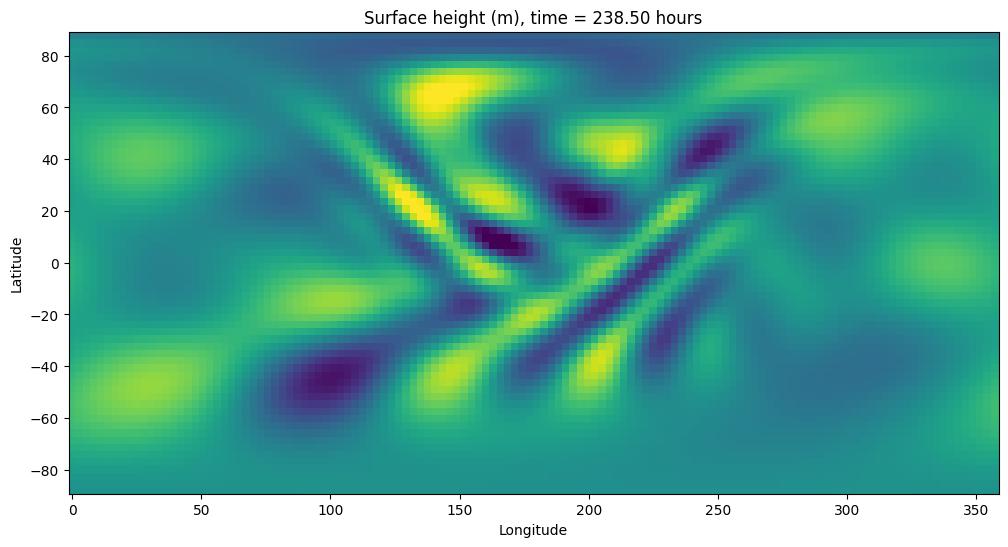

In [26]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. Notice that as the gravity waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

ADD **PLOTS** AND **DISCUSSION** HERE

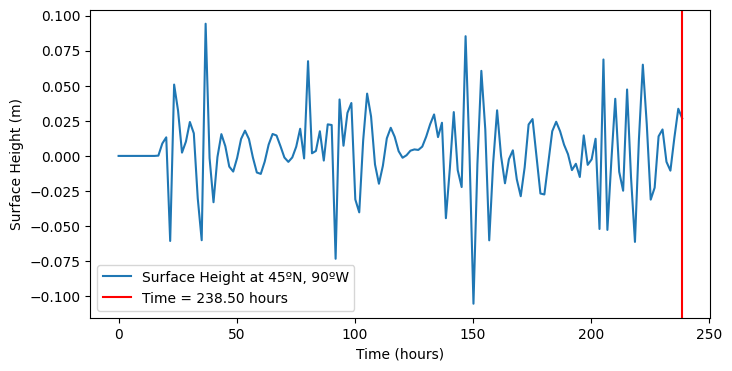

In [27]:
# at a latitude of 45ºN and longitude of 90ºW
gauge_lat = np.abs(lat - 45 * np.pi / 180).argmin()  # Convert 45 degrees to radians
gauge_lon = np.abs(phi + np.pi / 2).argmin()  # Convert -90 degrees to radians (90ºW)

# the height time series
h_gauge = h_save[:, gauge_lon, gauge_lat]

# Convert simulation time steps to hrs
t_hours = np.array([t / 3600 for t in t_save])

# Plot the time series of the surface h
plt.figure(figsize=(8, 4))
plt.plot(t_hours, h_gauge, label='Surface Height at 45ºN, 90ºW')

# at 238.50 hours to highlight the extracted slice time
plt.axvline(x=238.50, color='r', linestyle='-', label="Time = 238.50 hours")
plt.ylabel('Surface Height (m)')
plt.xlabel('Time (hours)')

# Displaying the legend
plt.legend()
plt.show()


**My Discussion:**

The time series plot above illustrates how the gravity wave changes, grow and interact with other waves during reflection. The first two huge peaks seen approximately between 10 km and 45 km, correspond to the first and second arrival of waves at the tide gauge with the second hump due to reflection of waves off the boundaries. The redline drawn at the sliced time of 238.50 hours, points out the wave form at this particular moment. Some of the waves arrival after these arrive and build constructively while at the same time they knock down the frequency and regular the amplitude. This is because on the globe, waves are interacting with their reflections all the time. Although the big humps of the picked-up strong wave remain large, they decrease in height in later oscillations due to energy dissipation in reflected oscillation.



**NOTE:**

**Tort M, Dubos T, Bouchut F, Zeitlin V.** *Consistent shallow-water equations on the rotating sphere with complete Coriolis force and topography*. Journal of Fluid Mechanics. 2014;748:789-821. doi:10.1017/jfm.2014.172

In the paper above from Cambridge Press "Consistent shallow-water equations are derived on the rotating sphere with topography retaining the Coriolis force due to the horizontal component of the planetary angular velocity. Unlike the traditional approximation, this 'non-traditional' approximation captures the increase with height of the solid-body velocity due to planetary rotation" From

```
# This is formatted as code
```

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the co-latitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves and compare them with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

**My Answer:**

The damping term is all that allows Rossby waves to build up and translate westward in the simulation. As for the phase speed estimation, I involve the analysis of zones of consecutive identification of waves concerning time and longitude. One can see in the figure below that the waves propagate at about 80 degrees traveled distance in radians in 110 hours.

Standard Rossby wave speed values are about 1m/s in the ocean, meaning that the simulation provides with a larger speed value. Of course, the given model oversimplifies the real world in many ways, including the absence of the landmasses and the uniformity of the damping which in actuality should be more localized. Also, the Coriolis parameter increases with latitude and the distance from the center of the earth and thus the rollers maybe faster at the equator.

Again, the wave patterns are better defined in the Southern Hemisphere than near the boundaries. The model Northern Hemisphere waves do not replicate the Southern Hemisphere waves, and this shows that the model starting conditions and symmetry provide only limited realism to Rossby waves.

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.7e+01/s


2024-12-19 14:33:54,777 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 4.7e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


2024-12-19 14:33:54,875 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 6.0e+01/s


2024-12-19 14:33:54,988 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 6.0e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


2024-12-19 14:33:55,114 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 6.0e+01/s


2024-12-19 14:33:55,224 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 6.0e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 6.0e+01/s


2024-12-19 14:33:55,342 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 6.0e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


2024-12-19 14:33:55,464 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


2024-12-19 14:33:55,587 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


2024-12-19 14:33:55,706 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


2024-12-19 14:33:55,832 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s


INFO:__main__:Starting main loop


2024-12-19 14:33:55,840 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.00e+02, dt=600


2024-12-19 14:34:00,945 __main__ 0/1 INFO :: Iteration=1, Time=6.00e+02, dt=600


INFO:__main__:Iteration=11, Time=6.60e+03, dt=600


2024-12-19 14:34:01,844 __main__ 0/1 INFO :: Iteration=11, Time=6.60e+03, dt=600


INFO:__main__:Iteration=21, Time=1.26e+04, dt=600


2024-12-19 14:34:02,408 __main__ 0/1 INFO :: Iteration=21, Time=1.26e+04, dt=600


INFO:__main__:Iteration=31, Time=1.86e+04, dt=600


2024-12-19 14:34:03,094 __main__ 0/1 INFO :: Iteration=31, Time=1.86e+04, dt=600


INFO:__main__:Iteration=41, Time=2.46e+04, dt=600


2024-12-19 14:34:03,637 __main__ 0/1 INFO :: Iteration=41, Time=2.46e+04, dt=600


INFO:__main__:Iteration=51, Time=3.06e+04, dt=600


2024-12-19 14:34:04,184 __main__ 0/1 INFO :: Iteration=51, Time=3.06e+04, dt=600


INFO:__main__:Iteration=61, Time=3.66e+04, dt=600


2024-12-19 14:34:04,725 __main__ 0/1 INFO :: Iteration=61, Time=3.66e+04, dt=600


INFO:__main__:Iteration=71, Time=4.26e+04, dt=600


2024-12-19 14:34:05,280 __main__ 0/1 INFO :: Iteration=71, Time=4.26e+04, dt=600


INFO:__main__:Iteration=81, Time=4.86e+04, dt=600


2024-12-19 14:34:05,823 __main__ 0/1 INFO :: Iteration=81, Time=4.86e+04, dt=600


INFO:__main__:Iteration=91, Time=5.46e+04, dt=600


2024-12-19 14:34:06,366 __main__ 0/1 INFO :: Iteration=91, Time=5.46e+04, dt=600


INFO:__main__:Iteration=101, Time=6.06e+04, dt=600


2024-12-19 14:34:06,899 __main__ 0/1 INFO :: Iteration=101, Time=6.06e+04, dt=600


INFO:__main__:Iteration=111, Time=6.66e+04, dt=600


2024-12-19 14:34:07,451 __main__ 0/1 INFO :: Iteration=111, Time=6.66e+04, dt=600


INFO:__main__:Iteration=121, Time=7.26e+04, dt=600


2024-12-19 14:34:07,989 __main__ 0/1 INFO :: Iteration=121, Time=7.26e+04, dt=600


INFO:__main__:Iteration=131, Time=7.86e+04, dt=600


2024-12-19 14:34:08,538 __main__ 0/1 INFO :: Iteration=131, Time=7.86e+04, dt=600


INFO:__main__:Iteration=141, Time=8.46e+04, dt=600


2024-12-19 14:34:09,152 __main__ 0/1 INFO :: Iteration=141, Time=8.46e+04, dt=600


INFO:__main__:Iteration=151, Time=9.06e+04, dt=600


2024-12-19 14:34:09,975 __main__ 0/1 INFO :: Iteration=151, Time=9.06e+04, dt=600


INFO:__main__:Iteration=161, Time=9.66e+04, dt=600


2024-12-19 14:34:10,860 __main__ 0/1 INFO :: Iteration=161, Time=9.66e+04, dt=600


INFO:__main__:Iteration=171, Time=1.03e+05, dt=600


2024-12-19 14:34:11,737 __main__ 0/1 INFO :: Iteration=171, Time=1.03e+05, dt=600


INFO:__main__:Iteration=181, Time=1.09e+05, dt=600


2024-12-19 14:34:12,605 __main__ 0/1 INFO :: Iteration=181, Time=1.09e+05, dt=600


INFO:__main__:Iteration=191, Time=1.15e+05, dt=600


2024-12-19 14:34:13,149 __main__ 0/1 INFO :: Iteration=191, Time=1.15e+05, dt=600


INFO:__main__:Iteration=201, Time=1.21e+05, dt=600


2024-12-19 14:34:13,712 __main__ 0/1 INFO :: Iteration=201, Time=1.21e+05, dt=600


INFO:__main__:Iteration=211, Time=1.27e+05, dt=600


2024-12-19 14:34:14,249 __main__ 0/1 INFO :: Iteration=211, Time=1.27e+05, dt=600


INFO:__main__:Iteration=221, Time=1.33e+05, dt=600


2024-12-19 14:34:14,795 __main__ 0/1 INFO :: Iteration=221, Time=1.33e+05, dt=600


INFO:__main__:Iteration=231, Time=1.39e+05, dt=600


2024-12-19 14:34:15,336 __main__ 0/1 INFO :: Iteration=231, Time=1.39e+05, dt=600


INFO:__main__:Iteration=241, Time=1.45e+05, dt=600


2024-12-19 14:34:15,910 __main__ 0/1 INFO :: Iteration=241, Time=1.45e+05, dt=600


INFO:__main__:Iteration=251, Time=1.51e+05, dt=600


2024-12-19 14:34:16,456 __main__ 0/1 INFO :: Iteration=251, Time=1.51e+05, dt=600


INFO:__main__:Iteration=261, Time=1.57e+05, dt=600


2024-12-19 14:34:17,014 __main__ 0/1 INFO :: Iteration=261, Time=1.57e+05, dt=600


INFO:__main__:Iteration=271, Time=1.63e+05, dt=600


2024-12-19 14:34:17,556 __main__ 0/1 INFO :: Iteration=271, Time=1.63e+05, dt=600


INFO:__main__:Iteration=281, Time=1.69e+05, dt=600


2024-12-19 14:34:18,101 __main__ 0/1 INFO :: Iteration=281, Time=1.69e+05, dt=600


INFO:__main__:Iteration=291, Time=1.75e+05, dt=600


2024-12-19 14:34:18,668 __main__ 0/1 INFO :: Iteration=291, Time=1.75e+05, dt=600


INFO:__main__:Iteration=301, Time=1.81e+05, dt=600


2024-12-19 14:34:19,209 __main__ 0/1 INFO :: Iteration=301, Time=1.81e+05, dt=600


INFO:__main__:Iteration=311, Time=1.87e+05, dt=600


2024-12-19 14:34:19,752 __main__ 0/1 INFO :: Iteration=311, Time=1.87e+05, dt=600


INFO:__main__:Iteration=321, Time=1.93e+05, dt=600


2024-12-19 14:34:20,274 __main__ 0/1 INFO :: Iteration=321, Time=1.93e+05, dt=600


INFO:__main__:Iteration=331, Time=1.99e+05, dt=600


2024-12-19 14:34:20,847 __main__ 0/1 INFO :: Iteration=331, Time=1.99e+05, dt=600


INFO:__main__:Iteration=341, Time=2.05e+05, dt=600


2024-12-19 14:34:21,397 __main__ 0/1 INFO :: Iteration=341, Time=2.05e+05, dt=600


INFO:__main__:Iteration=351, Time=2.11e+05, dt=600


2024-12-19 14:34:21,950 __main__ 0/1 INFO :: Iteration=351, Time=2.11e+05, dt=600


INFO:__main__:Iteration=361, Time=2.17e+05, dt=600


2024-12-19 14:34:22,528 __main__ 0/1 INFO :: Iteration=361, Time=2.17e+05, dt=600


INFO:__main__:Iteration=371, Time=2.23e+05, dt=600


2024-12-19 14:34:23,353 __main__ 0/1 INFO :: Iteration=371, Time=2.23e+05, dt=600


INFO:__main__:Iteration=381, Time=2.29e+05, dt=600


2024-12-19 14:34:24,151 __main__ 0/1 INFO :: Iteration=381, Time=2.29e+05, dt=600


INFO:__main__:Iteration=391, Time=2.35e+05, dt=600


2024-12-19 14:34:25,001 __main__ 0/1 INFO :: Iteration=391, Time=2.35e+05, dt=600


INFO:__main__:Iteration=401, Time=2.41e+05, dt=600


2024-12-19 14:34:25,869 __main__ 0/1 INFO :: Iteration=401, Time=2.41e+05, dt=600


INFO:__main__:Iteration=411, Time=2.47e+05, dt=600


2024-12-19 14:34:26,521 __main__ 0/1 INFO :: Iteration=411, Time=2.47e+05, dt=600


INFO:__main__:Iteration=421, Time=2.53e+05, dt=600


2024-12-19 14:34:27,073 __main__ 0/1 INFO :: Iteration=421, Time=2.53e+05, dt=600


INFO:__main__:Iteration=431, Time=2.59e+05, dt=600


2024-12-19 14:34:27,627 __main__ 0/1 INFO :: Iteration=431, Time=2.59e+05, dt=600


INFO:__main__:Iteration=441, Time=2.65e+05, dt=600


2024-12-19 14:34:28,167 __main__ 0/1 INFO :: Iteration=441, Time=2.65e+05, dt=600


INFO:__main__:Iteration=451, Time=2.71e+05, dt=600


2024-12-19 14:34:28,707 __main__ 0/1 INFO :: Iteration=451, Time=2.71e+05, dt=600


INFO:__main__:Iteration=461, Time=2.77e+05, dt=600


2024-12-19 14:34:29,253 __main__ 0/1 INFO :: Iteration=461, Time=2.77e+05, dt=600


INFO:__main__:Iteration=471, Time=2.83e+05, dt=600


2024-12-19 14:34:29,798 __main__ 0/1 INFO :: Iteration=471, Time=2.83e+05, dt=600


INFO:__main__:Iteration=481, Time=2.89e+05, dt=600


2024-12-19 14:34:30,349 __main__ 0/1 INFO :: Iteration=481, Time=2.89e+05, dt=600


INFO:__main__:Iteration=491, Time=2.95e+05, dt=600


2024-12-19 14:34:30,888 __main__ 0/1 INFO :: Iteration=491, Time=2.95e+05, dt=600


INFO:__main__:Iteration=501, Time=3.01e+05, dt=600


2024-12-19 14:34:31,468 __main__ 0/1 INFO :: Iteration=501, Time=3.01e+05, dt=600


INFO:__main__:Iteration=511, Time=3.07e+05, dt=600


2024-12-19 14:34:32,056 __main__ 0/1 INFO :: Iteration=511, Time=3.07e+05, dt=600


INFO:__main__:Iteration=521, Time=3.13e+05, dt=600


2024-12-19 14:34:32,625 __main__ 0/1 INFO :: Iteration=521, Time=3.13e+05, dt=600


INFO:__main__:Iteration=531, Time=3.19e+05, dt=600


2024-12-19 14:34:33,190 __main__ 0/1 INFO :: Iteration=531, Time=3.19e+05, dt=600


INFO:__main__:Iteration=541, Time=3.25e+05, dt=600


2024-12-19 14:34:33,730 __main__ 0/1 INFO :: Iteration=541, Time=3.25e+05, dt=600


INFO:__main__:Iteration=551, Time=3.31e+05, dt=600


2024-12-19 14:34:34,268 __main__ 0/1 INFO :: Iteration=551, Time=3.31e+05, dt=600


INFO:__main__:Iteration=561, Time=3.37e+05, dt=600


2024-12-19 14:34:34,865 __main__ 0/1 INFO :: Iteration=561, Time=3.37e+05, dt=600


INFO:__main__:Iteration=571, Time=3.43e+05, dt=600


2024-12-19 14:34:35,419 __main__ 0/1 INFO :: Iteration=571, Time=3.43e+05, dt=600


INFO:__main__:Iteration=581, Time=3.49e+05, dt=600


2024-12-19 14:34:35,970 __main__ 0/1 INFO :: Iteration=581, Time=3.49e+05, dt=600


INFO:__main__:Iteration=591, Time=3.55e+05, dt=600


2024-12-19 14:34:36,734 __main__ 0/1 INFO :: Iteration=591, Time=3.55e+05, dt=600


INFO:__main__:Iteration=601, Time=3.61e+05, dt=600


2024-12-19 14:34:37,570 __main__ 0/1 INFO :: Iteration=601, Time=3.61e+05, dt=600


INFO:__main__:Iteration=611, Time=3.67e+05, dt=600


2024-12-19 14:34:38,460 __main__ 0/1 INFO :: Iteration=611, Time=3.67e+05, dt=600


INFO:__main__:Iteration=621, Time=3.73e+05, dt=600


2024-12-19 14:34:39,356 __main__ 0/1 INFO :: Iteration=621, Time=3.73e+05, dt=600


INFO:__main__:Iteration=631, Time=3.79e+05, dt=600


2024-12-19 14:34:39,922 __main__ 0/1 INFO :: Iteration=631, Time=3.79e+05, dt=600


INFO:__main__:Iteration=641, Time=3.85e+05, dt=600


2024-12-19 14:34:40,485 __main__ 0/1 INFO :: Iteration=641, Time=3.85e+05, dt=600


INFO:__main__:Iteration=651, Time=3.91e+05, dt=600


2024-12-19 14:34:41,014 __main__ 0/1 INFO :: Iteration=651, Time=3.91e+05, dt=600


INFO:__main__:Iteration=661, Time=3.97e+05, dt=600


2024-12-19 14:34:41,597 __main__ 0/1 INFO :: Iteration=661, Time=3.97e+05, dt=600


INFO:__main__:Iteration=671, Time=4.03e+05, dt=600


2024-12-19 14:34:42,150 __main__ 0/1 INFO :: Iteration=671, Time=4.03e+05, dt=600


INFO:__main__:Iteration=681, Time=4.09e+05, dt=600


2024-12-19 14:34:42,719 __main__ 0/1 INFO :: Iteration=681, Time=4.09e+05, dt=600


INFO:__main__:Iteration=691, Time=4.15e+05, dt=600


2024-12-19 14:34:43,277 __main__ 0/1 INFO :: Iteration=691, Time=4.15e+05, dt=600


INFO:__main__:Iteration=701, Time=4.21e+05, dt=600


2024-12-19 14:34:43,852 __main__ 0/1 INFO :: Iteration=701, Time=4.21e+05, dt=600


INFO:__main__:Iteration=711, Time=4.27e+05, dt=600


2024-12-19 14:34:44,403 __main__ 0/1 INFO :: Iteration=711, Time=4.27e+05, dt=600


INFO:__main__:Iteration=721, Time=4.33e+05, dt=600


2024-12-19 14:34:44,961 __main__ 0/1 INFO :: Iteration=721, Time=4.33e+05, dt=600


INFO:__main__:Iteration=731, Time=4.39e+05, dt=600


2024-12-19 14:34:45,519 __main__ 0/1 INFO :: Iteration=731, Time=4.39e+05, dt=600


INFO:__main__:Iteration=741, Time=4.45e+05, dt=600


2024-12-19 14:34:46,060 __main__ 0/1 INFO :: Iteration=741, Time=4.45e+05, dt=600


INFO:__main__:Iteration=751, Time=4.51e+05, dt=600


2024-12-19 14:34:46,622 __main__ 0/1 INFO :: Iteration=751, Time=4.51e+05, dt=600


INFO:__main__:Iteration=761, Time=4.57e+05, dt=600


2024-12-19 14:34:47,161 __main__ 0/1 INFO :: Iteration=761, Time=4.57e+05, dt=600


INFO:__main__:Iteration=771, Time=4.63e+05, dt=600


2024-12-19 14:34:47,714 __main__ 0/1 INFO :: Iteration=771, Time=4.63e+05, dt=600


INFO:__main__:Iteration=781, Time=4.69e+05, dt=600


2024-12-19 14:34:48,242 __main__ 0/1 INFO :: Iteration=781, Time=4.69e+05, dt=600


INFO:__main__:Iteration=791, Time=4.75e+05, dt=600


2024-12-19 14:34:48,793 __main__ 0/1 INFO :: Iteration=791, Time=4.75e+05, dt=600


INFO:__main__:Iteration=801, Time=4.81e+05, dt=600


2024-12-19 14:34:49,347 __main__ 0/1 INFO :: Iteration=801, Time=4.81e+05, dt=600


INFO:__main__:Iteration=811, Time=4.87e+05, dt=600


2024-12-19 14:34:50,198 __main__ 0/1 INFO :: Iteration=811, Time=4.87e+05, dt=600


INFO:__main__:Iteration=821, Time=4.93e+05, dt=600


2024-12-19 14:34:51,005 __main__ 0/1 INFO :: Iteration=821, Time=4.93e+05, dt=600


INFO:__main__:Iteration=831, Time=4.99e+05, dt=600


2024-12-19 14:34:51,862 __main__ 0/1 INFO :: Iteration=831, Time=4.99e+05, dt=600


INFO:__main__:Iteration=841, Time=5.05e+05, dt=600


2024-12-19 14:34:52,694 __main__ 0/1 INFO :: Iteration=841, Time=5.05e+05, dt=600


INFO:__main__:Iteration=851, Time=5.11e+05, dt=600


2024-12-19 14:34:53,246 __main__ 0/1 INFO :: Iteration=851, Time=5.11e+05, dt=600


INFO:__main__:Iteration=861, Time=5.17e+05, dt=600


2024-12-19 14:34:53,798 __main__ 0/1 INFO :: Iteration=861, Time=5.17e+05, dt=600


INFO:__main__:Iteration=871, Time=5.23e+05, dt=600


2024-12-19 14:34:54,357 __main__ 0/1 INFO :: Iteration=871, Time=5.23e+05, dt=600


INFO:__main__:Iteration=881, Time=5.29e+05, dt=600


2024-12-19 14:34:54,881 __main__ 0/1 INFO :: Iteration=881, Time=5.29e+05, dt=600


INFO:__main__:Iteration=891, Time=5.35e+05, dt=600


2024-12-19 14:34:55,474 __main__ 0/1 INFO :: Iteration=891, Time=5.35e+05, dt=600


INFO:__main__:Iteration=901, Time=5.41e+05, dt=600


2024-12-19 14:34:56,046 __main__ 0/1 INFO :: Iteration=901, Time=5.41e+05, dt=600


INFO:__main__:Iteration=911, Time=5.47e+05, dt=600


2024-12-19 14:34:56,608 __main__ 0/1 INFO :: Iteration=911, Time=5.47e+05, dt=600


INFO:__main__:Iteration=921, Time=5.53e+05, dt=600


2024-12-19 14:34:57,171 __main__ 0/1 INFO :: Iteration=921, Time=5.53e+05, dt=600


INFO:__main__:Iteration=931, Time=5.59e+05, dt=600


2024-12-19 14:34:57,716 __main__ 0/1 INFO :: Iteration=931, Time=5.59e+05, dt=600


INFO:__main__:Iteration=941, Time=5.65e+05, dt=600


2024-12-19 14:34:58,262 __main__ 0/1 INFO :: Iteration=941, Time=5.65e+05, dt=600


INFO:__main__:Iteration=951, Time=5.71e+05, dt=600


2024-12-19 14:34:58,808 __main__ 0/1 INFO :: Iteration=951, Time=5.71e+05, dt=600


INFO:__main__:Iteration=961, Time=5.77e+05, dt=600


2024-12-19 14:34:59,372 __main__ 0/1 INFO :: Iteration=961, Time=5.77e+05, dt=600


INFO:__main__:Iteration=971, Time=5.83e+05, dt=600


2024-12-19 14:34:59,918 __main__ 0/1 INFO :: Iteration=971, Time=5.83e+05, dt=600


INFO:__main__:Iteration=981, Time=5.89e+05, dt=600


2024-12-19 14:35:00,498 __main__ 0/1 INFO :: Iteration=981, Time=5.89e+05, dt=600


INFO:__main__:Iteration=991, Time=5.95e+05, dt=600


2024-12-19 14:35:01,046 __main__ 0/1 INFO :: Iteration=991, Time=5.95e+05, dt=600


INFO:__main__:Iteration=1001, Time=6.01e+05, dt=600


2024-12-19 14:35:01,598 __main__ 0/1 INFO :: Iteration=1001, Time=6.01e+05, dt=600


INFO:__main__:Iteration=1011, Time=6.07e+05, dt=600


2024-12-19 14:35:02,141 __main__ 0/1 INFO :: Iteration=1011, Time=6.07e+05, dt=600


INFO:__main__:Iteration=1021, Time=6.13e+05, dt=600


2024-12-19 14:35:02,732 __main__ 0/1 INFO :: Iteration=1021, Time=6.13e+05, dt=600


INFO:__main__:Iteration=1031, Time=6.19e+05, dt=600


2024-12-19 14:35:03,560 __main__ 0/1 INFO :: Iteration=1031, Time=6.19e+05, dt=600


INFO:__main__:Iteration=1041, Time=6.25e+05, dt=600


2024-12-19 14:35:04,382 __main__ 0/1 INFO :: Iteration=1041, Time=6.25e+05, dt=600


INFO:__main__:Iteration=1051, Time=6.31e+05, dt=600


2024-12-19 14:35:05,266 __main__ 0/1 INFO :: Iteration=1051, Time=6.31e+05, dt=600


INFO:__main__:Iteration=1061, Time=6.37e+05, dt=600


2024-12-19 14:35:06,123 __main__ 0/1 INFO :: Iteration=1061, Time=6.37e+05, dt=600


INFO:__main__:Iteration=1071, Time=6.43e+05, dt=600


2024-12-19 14:35:06,674 __main__ 0/1 INFO :: Iteration=1071, Time=6.43e+05, dt=600


INFO:__main__:Iteration=1081, Time=6.49e+05, dt=600


2024-12-19 14:35:07,216 __main__ 0/1 INFO :: Iteration=1081, Time=6.49e+05, dt=600


INFO:__main__:Iteration=1091, Time=6.55e+05, dt=600


2024-12-19 14:35:07,765 __main__ 0/1 INFO :: Iteration=1091, Time=6.55e+05, dt=600


INFO:__main__:Iteration=1101, Time=6.61e+05, dt=600


2024-12-19 14:35:08,306 __main__ 0/1 INFO :: Iteration=1101, Time=6.61e+05, dt=600


INFO:__main__:Iteration=1111, Time=6.67e+05, dt=600


2024-12-19 14:35:08,861 __main__ 0/1 INFO :: Iteration=1111, Time=6.67e+05, dt=600


INFO:__main__:Iteration=1121, Time=6.73e+05, dt=600


2024-12-19 14:35:09,400 __main__ 0/1 INFO :: Iteration=1121, Time=6.73e+05, dt=600


INFO:__main__:Iteration=1131, Time=6.79e+05, dt=600


2024-12-19 14:35:09,986 __main__ 0/1 INFO :: Iteration=1131, Time=6.79e+05, dt=600


INFO:__main__:Iteration=1141, Time=6.85e+05, dt=600


2024-12-19 14:35:10,574 __main__ 0/1 INFO :: Iteration=1141, Time=6.85e+05, dt=600


INFO:__main__:Iteration=1151, Time=6.91e+05, dt=600


2024-12-19 14:35:11,140 __main__ 0/1 INFO :: Iteration=1151, Time=6.91e+05, dt=600


INFO:__main__:Iteration=1161, Time=6.97e+05, dt=600


2024-12-19 14:35:11,695 __main__ 0/1 INFO :: Iteration=1161, Time=6.97e+05, dt=600


INFO:__main__:Iteration=1171, Time=7.03e+05, dt=600


2024-12-19 14:35:12,241 __main__ 0/1 INFO :: Iteration=1171, Time=7.03e+05, dt=600


INFO:__main__:Iteration=1181, Time=7.09e+05, dt=600


2024-12-19 14:35:12,802 __main__ 0/1 INFO :: Iteration=1181, Time=7.09e+05, dt=600


INFO:__main__:Iteration=1191, Time=7.15e+05, dt=600


2024-12-19 14:35:13,351 __main__ 0/1 INFO :: Iteration=1191, Time=7.15e+05, dt=600


INFO:__main__:Iteration=1201, Time=7.21e+05, dt=600


2024-12-19 14:35:13,903 __main__ 0/1 INFO :: Iteration=1201, Time=7.21e+05, dt=600


INFO:__main__:Iteration=1211, Time=7.27e+05, dt=600


2024-12-19 14:35:14,452 __main__ 0/1 INFO :: Iteration=1211, Time=7.27e+05, dt=600


INFO:__main__:Iteration=1221, Time=7.33e+05, dt=600


2024-12-19 14:35:15,029 __main__ 0/1 INFO :: Iteration=1221, Time=7.33e+05, dt=600


INFO:__main__:Iteration=1231, Time=7.39e+05, dt=600


2024-12-19 14:35:15,595 __main__ 0/1 INFO :: Iteration=1231, Time=7.39e+05, dt=600


INFO:__main__:Iteration=1241, Time=7.45e+05, dt=600


2024-12-19 14:35:16,206 __main__ 0/1 INFO :: Iteration=1241, Time=7.45e+05, dt=600


INFO:__main__:Iteration=1251, Time=7.51e+05, dt=600


2024-12-19 14:35:17,126 __main__ 0/1 INFO :: Iteration=1251, Time=7.51e+05, dt=600


INFO:__main__:Iteration=1261, Time=7.57e+05, dt=600


2024-12-19 14:35:18,028 __main__ 0/1 INFO :: Iteration=1261, Time=7.57e+05, dt=600


INFO:__main__:Iteration=1271, Time=7.63e+05, dt=600


2024-12-19 14:35:18,880 __main__ 0/1 INFO :: Iteration=1271, Time=7.63e+05, dt=600


INFO:__main__:Iteration=1281, Time=7.69e+05, dt=600


2024-12-19 14:35:19,663 __main__ 0/1 INFO :: Iteration=1281, Time=7.69e+05, dt=600


INFO:__main__:Iteration=1291, Time=7.75e+05, dt=600


2024-12-19 14:35:20,209 __main__ 0/1 INFO :: Iteration=1291, Time=7.75e+05, dt=600


INFO:__main__:Iteration=1301, Time=7.81e+05, dt=600


2024-12-19 14:35:20,758 __main__ 0/1 INFO :: Iteration=1301, Time=7.81e+05, dt=600


INFO:__main__:Iteration=1311, Time=7.87e+05, dt=600


2024-12-19 14:35:21,324 __main__ 0/1 INFO :: Iteration=1311, Time=7.87e+05, dt=600


INFO:__main__:Iteration=1321, Time=7.93e+05, dt=600


2024-12-19 14:35:21,864 __main__ 0/1 INFO :: Iteration=1321, Time=7.93e+05, dt=600


INFO:__main__:Iteration=1331, Time=7.99e+05, dt=600


2024-12-19 14:35:22,414 __main__ 0/1 INFO :: Iteration=1331, Time=7.99e+05, dt=600


INFO:__main__:Iteration=1341, Time=8.05e+05, dt=600


2024-12-19 14:35:22,945 __main__ 0/1 INFO :: Iteration=1341, Time=8.05e+05, dt=600


INFO:__main__:Iteration=1351, Time=8.11e+05, dt=600


2024-12-19 14:35:23,503 __main__ 0/1 INFO :: Iteration=1351, Time=8.11e+05, dt=600


INFO:__main__:Iteration=1361, Time=8.17e+05, dt=600


2024-12-19 14:35:24,113 __main__ 0/1 INFO :: Iteration=1361, Time=8.17e+05, dt=600


INFO:__main__:Iteration=1371, Time=8.23e+05, dt=600


2024-12-19 14:35:24,673 __main__ 0/1 INFO :: Iteration=1371, Time=8.23e+05, dt=600


INFO:__main__:Iteration=1381, Time=8.29e+05, dt=600


2024-12-19 14:35:25,234 __main__ 0/1 INFO :: Iteration=1381, Time=8.29e+05, dt=600


INFO:__main__:Iteration=1391, Time=8.35e+05, dt=600


2024-12-19 14:35:25,789 __main__ 0/1 INFO :: Iteration=1391, Time=8.35e+05, dt=600


INFO:__main__:Iteration=1401, Time=8.41e+05, dt=600


2024-12-19 14:35:26,346 __main__ 0/1 INFO :: Iteration=1401, Time=8.41e+05, dt=600


INFO:__main__:Iteration=1411, Time=8.47e+05, dt=600


2024-12-19 14:35:26,891 __main__ 0/1 INFO :: Iteration=1411, Time=8.47e+05, dt=600


INFO:__main__:Iteration=1421, Time=8.53e+05, dt=600


2024-12-19 14:35:27,445 __main__ 0/1 INFO :: Iteration=1421, Time=8.53e+05, dt=600


INFO:__main__:Iteration=1431, Time=8.59e+05, dt=600


2024-12-19 14:35:27,980 __main__ 0/1 INFO :: Iteration=1431, Time=8.59e+05, dt=600


INFO:solvers:Simulation stop time reached.


2024-12-19 14:35:28,501 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2024-12-19 14:35:28,505 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2024-12-19 14:35:28,510 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 5.39 sec


2024-12-19 14:35:28,514 solvers 0/1 INFO :: Setup time (init - iter 0): 5.39 sec


INFO:solvers:Warmup time (iter 0-10): 1.701 sec


2024-12-19 14:35:28,516 solvers 0/1 INFO :: Warmup time (iter 0-10): 1.701 sec


INFO:solvers:Run time (iter 10-end): 86.71 sec


2024-12-19 14:35:28,519 solvers 0/1 INFO :: Run time (iter 10-end): 86.71 sec


INFO:solvers:CPU time (iter 10-end): 0.02409 cpu-hr


2024-12-19 14:35:28,522 solvers 0/1 INFO :: CPU time (iter 10-end): 0.02409 cpu-hr


INFO:solvers:Speed: 3.988e+05 mode-stages/cpu-sec


2024-12-19 14:35:28,531 solvers 0/1 INFO :: Speed: 3.988e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2024-12-19 14:35:28,845 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpn3d3hbax/temp.m4v


2024-12-19 14:35:28,849 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpn3d3hbax/temp.m4v


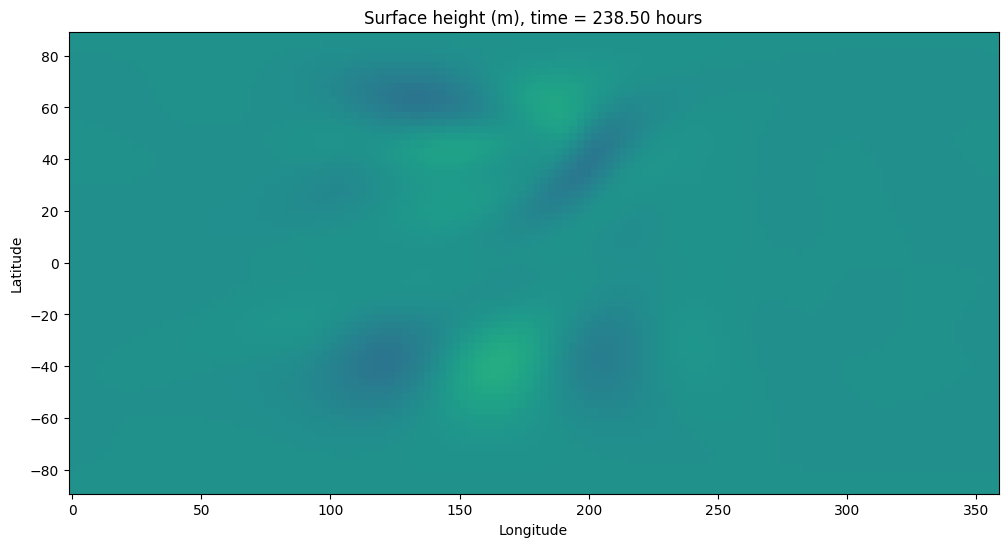

In [28]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

# Logger for debugging and tracking progress
logger = logging.getLogger(__name__)

# Define simulation units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters for the simulation
Nphi = 128  # Number of gridpoints in phi (longitude)
Ntheta = 64  # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer  # Radius of Earth (km)
Omega = 2 * np.pi / day  # Earth's angular velocity (rad/s)
g = 9.80616 * meter / second**2  # Gravitational acceleration (m/s^2)
H = 4 * kilometer  # Ocean depth (km)
width = 2 * np.pi * 10 / 360  # Initial Gaussian width in radians
phi0 = np.pi  # Longitude of the initial perturbation (rad)
theta0 = np.pi / 4  # Colatitude of the initial perturbation (rad)
tau = 0.1 * day  # Damping timescale (days)

# Time settings
timestep = 600 * second  # Time step (s)
stop_sim_time = 10 * day  # Total simulation time (s)

# Create coordinate system
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis)  # Longitude and colatitude (rad)
lat = 360 * (np.pi / 2 - theta) / (2 * np.pi)  # Latitude in degrees

# Create fields
u = dist.VectorField(coords, name='u', bases=basis)  # Velocity field (u, v components)
h = dist.Field(name='h', bases=basis)  # Surface height field

# Damping function for longitudes beyond ±90°
f = dist.Field(name='f', bases=basis)
f['g'] = 0.5 * (1 + np.tanh((phi - 3 * np.pi / 2) / (np.pi / 10))) + 0.5 * (1 - np.tanh((phi - np.pi / 2) / (np.pi / 10)))

# Cross-product operator for the velocity field
zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))

# Set initial conditions for the fields
h.change_scales(1)  # Set values on regular grid
u.change_scales(1)

# Initial perturbation: Gaussian function for the surface height
h['g'] = np.exp(-((phi - phi0) ** 2 + (theta - theta0) ** 2) / width ** 2)

# Initial velocity is zero
u['g'][0] = 0  # x-component of the velocity
u['g'][1] = 0  # y-component of the velocity

# Problem definition with equations
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g * grad(h) + 2 * Omega * zcross(u) = - u @ grad(u)")  # Momentum equation
problem.add_equation("dt(h) + H * div(u) = - div(h * u) - (1 / tau) * f * h")  # Shallow water height equation with damping

# Solver setup
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Initialize variables to save the output
h_save = [np.copy(h['g'])]
t_save = [solver.sim_time]

# Main simulation loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration - 1) % 10 == 0:
            logger.info(f'Iteration={solver.iteration}, Time={solver.sim_time:.2e}, dt={timestep}')
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the saved data to a NumPy array for easier handling
h_save = np.array(h_save)

# Plotting the results
fig = plt.figure(figsize=(12, 6))

# Create the meshgrid for plotting using longitude and latitude
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi / 2 - theta) * 360 / (2 * np.pi), np.squeeze(phi) * 360 / (2 * np.pi))

# Animation function to update the plot for each time step
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n, :, :], vmin=-0.1, vmax=0.1)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Surface height (m), time = {t_save[n] / hour:.2f} hours')
    return (height,)

# Create the animation using the saved data
from matplotlib import animation
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

# Display the animation
from IPython.display import HTML
HTML(anim.to_html5_video())


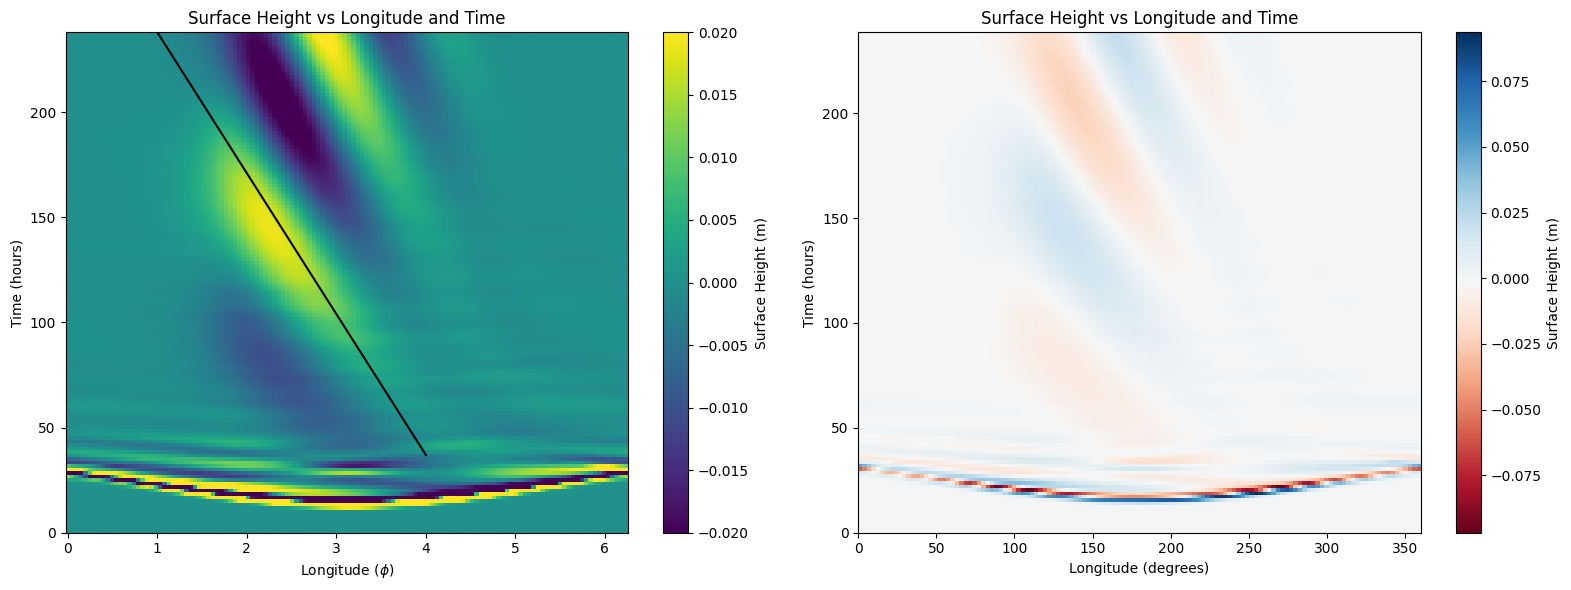

In [29]:
# phase speed estimation
def straight(x, m, c):
    y = m * x + c
    return y

# longitude range for plotting the straight line
phi_line = np.linspace(1, 4, 10)

# latitude index for gauge at 45 degrees
gauge_lat = np.abs(lat + 45).argmin()

# surface height values
h_at_lat = h_save[:, :, gauge_lat]

# time steps to hours
t_hours = [t / 3600 for t in t_save]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

pc = axes[0].pcolormesh(phi[:, 0], t_hours, h_at_lat, vmax=0.02, vmin=-0.02)
axes[0].set_xlabel('Longitude ($\phi$)')
axes[0].set_ylabel('Time (hours)')
axes[0].set_title('Surface Height vs Longitude and Time')
fig.colorbar(pc, ax=axes[0], label='Surface Height (m)')

phi_line = np.linspace(1, 4, 10)
axes[0].plot(phi_line, straight(phi_line, -67, 305), color='k', label='Phase Speed Estimate')
axes[0].set_ylim(0, 238)

# Plot the surface height at the gauge latitude
im = axes[1].imshow(h_save[:, :, gauge_lat], aspect='auto', extent=[0, 360, t_save[0] / hour, t_save[-1] / hour],
                    origin='lower', cmap='RdBu')
axes[1].set_xlabel('Longitude (degrees)')
axes[1].set_ylabel('Time (hours)')
axes[1].set_title('Surface Height vs Longitude and Time')
fig.colorbar(im, ax=axes[1], label='Surface Height (m)')

plt.tight_layout()
plt.show()


## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?